# Generative Model for SVHN Image and Label Synthesis

The objective of this hackathon is to develop a generative model capable of creating high-quality Street View House Numbers (SVHN) images along with corresponding accurate labels. Your generative model output will be used as the input data for a fixed classifier training. The best performing classifier wins the hackathon. Participants are required to submit a model checkpoint and two Colab notebooks—one for training and the other for model evaluation. The evaluation notebook can be found [here](https://colab.research.google.com/drive/1Fppb25hJJiYhcbx4zZby-XScdFR32IhF?usp=sharing).

## Tasks
- **Model Definition:** Define a generative model capable of producing samples from the SVHN data distribution, conditioned on a class label. These synthetic images will serve as input data for training the classifier during the evaluation phase.
- **Training:** Train your generative model using the SVHN dataset, ensuring high quality and diversity in the generated samples.
- **Model Checkpoint:** Save the weights of your trained generative model for evaluation and  submission.


## Evaluation Criteria

The generator models are evaluated by training a fixed classifier on their generated data, and measuring the classifier performance on an evaluation dataset. You can not modify the classifier or its training. The classifier is trained with 3 seeds. The 3 seeds are going to be changed for the final evaluation and the leaderboard to avoid overfitting to these seeds.

## Constraints

- **Data:** Participants are prohibited from loading any external data except the SVHN training set.
- **Model:**  
 - Participants are prohibited from loading pre-trained (not trained by you) models.
 - The model needs to be able to generate samples that are not present in the training dataset.
 - The model has to be a generative model and cannot store any training samples.
 - Model output should depend on random noise.
- **Compute:**  Model can generate 1000 samples within 3 seconds on the snowflake cluster or colab, using a maximum of 10GB of GPU memory.
-**Collaboration:** All teams must have individual slutions, and can not collaborate with other teams.

## Submission

The submission needs to include the following files:

- **Model Checkpoint:** Participants must provide a model checkpoint containing the trained generative model.

- **Training Notebook:** A Colab notebook exclusively for training the generative model. Participants should include preprocessing steps, model definition, and training procedures.

- **Evaluation Notebook:** The notebook designated for model evaluation. It should contain the model definition and the generate function, as specified in the evaluation notebook.

Zip the 3 files, rename it to the last name of all team members (in lowercase separated by underscores) and
[submit it here](https://polybox.ethz.ch/index.php/s/p2BVHpyExJErKu4).
So a team of Harry Potter, Hermione Granger and Ron Weasley would submit the zip file `potter_granger_weasley.zip`

**Now go an read the evaluation notebook!**

In [ ]:
import torch
from torch import optim
import os
import torchvision.utils as vutils
import numpy as np
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from itertools import islice
from tqdm import tqdm
import pickle
import torch
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import os
from torch.autograd import Variable # extra
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
from google.colab import drive

In [ ]:
# Arguments
BATCH_SIZE = 128
Z_DIM = 100
LABEL_EMBED_SIZE = 5
NUM_CLASSES = 10
IMGS_TO_DISPLAY_PER_CLASS = 20
LOAD_MODEL = False

DB = 'SVHN'

CHANNELS = 3
EPOCHS = 100

In [ ]:
# Directories for storing data, model and output samples
db_path = os.path.join('./data', DB)
os.makedirs(db_path, exist_ok=True)
model_path = os.path.join('./model', DB)
os.makedirs(model_path, exist_ok=True)
samples_path = os.path.join('./samples', DB)
os.makedirs(samples_path, exist_ok=True)

# Data loader
transform = transforms.ToTensor()

dataset = datasets.SVHN(db_path, split='train', download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        #num_workers=1,
                                        drop_last=True)

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/hodl/'

def save_checkpoint(model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    checkpoint_filename = f'checkpoint_epoch_{epoch}.pth'
    checkpoint_filepath = checkpoint_path + checkpoint_filename
    torch.save(checkpoint, checkpoint_filepath)
    print(f"Checkpoint saved at: {checkpoint_filepath}")


def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from: {checkpoint_path}")
    return model, optimizer, epoch, loss

drive.mount('/content/gdrive', force_remount=True)

start_epoch = 0
# latest_checkpoint = '/content/gdrive/MyDrive/hodl/checkpoint_epoch_99.pth'
# model, optimizer, start_epoch, start_loss = load_checkpoint(model, optimizer, latest_checkpoint) = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)


In [ ]:
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x

In [101]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = 32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = torch.sigmoid(self.conv4(x))
        return x.squeeze()

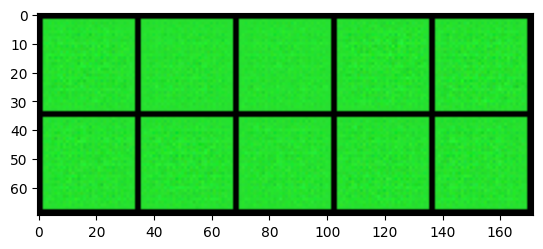

Epoch: 1/100	iter: 0/572	total_iters: 1	d_loss:0.7963	g_loss:0.8497
Epoch: 1/100	iter: 50/572	total_iters: 51	d_loss:0.4639	g_loss:2.6599
Epoch: 1/100	iter: 100/572	total_iters: 101	d_loss:0.4563	g_loss:1.7502
Epoch: 1/100	iter: 150/572	total_iters: 151	d_loss:0.7456	g_loss:1.2447
Epoch: 1/100	iter: 200/572	total_iters: 201	d_loss:0.6263	g_loss:2.4607
Epoch: 1/100	iter: 250/572	total_iters: 251	d_loss:0.4116	g_loss:1.7896
Epoch: 1/100	iter: 300/572	total_iters: 301	d_loss:0.5761	g_loss:1.7295
Epoch: 1/100	iter: 350/572	total_iters: 351	d_loss:0.3232	g_loss:1.6927
Epoch: 1/100	iter: 400/572	total_iters: 401	d_loss:0.5273	g_loss:3.7697
Epoch: 1/100	iter: 450/572	total_iters: 451	d_loss:0.6958	g_loss:1.0374
Epoch: 1/100	iter: 500/572	total_iters: 501	d_loss:0.4012	g_loss:1.6759
Epoch: 1/100	iter: 550/572	total_iters: 551	d_loss:0.5975	g_loss:1.9986


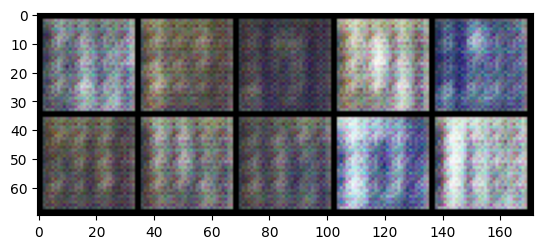

Epoch: 2/100	iter: 0/572	total_iters: 573	d_loss:0.3786	g_loss:1.685
Epoch: 2/100	iter: 50/572	total_iters: 623	d_loss:0.4741	g_loss:2.6564
Epoch: 2/100	iter: 100/572	total_iters: 673	d_loss:0.5959	g_loss:2.1166
Epoch: 2/100	iter: 150/572	total_iters: 723	d_loss:0.4147	g_loss:1.3764
Epoch: 2/100	iter: 200/572	total_iters: 773	d_loss:0.5251	g_loss:1.7097
Epoch: 2/100	iter: 250/572	total_iters: 823	d_loss:0.4056	g_loss:1.8511
Epoch: 2/100	iter: 300/572	total_iters: 873	d_loss:0.4121	g_loss:2.0895
Epoch: 2/100	iter: 350/572	total_iters: 923	d_loss:0.6848	g_loss:1.1611
Epoch: 2/100	iter: 400/572	total_iters: 973	d_loss:0.4249	g_loss:1.6492
Epoch: 2/100	iter: 450/572	total_iters: 1023	d_loss:0.5107	g_loss:0.9704
Epoch: 2/100	iter: 500/572	total_iters: 1073	d_loss:0.681	g_loss:0.907
Epoch: 2/100	iter: 550/572	total_iters: 1123	d_loss:0.5037	g_loss:1.3256


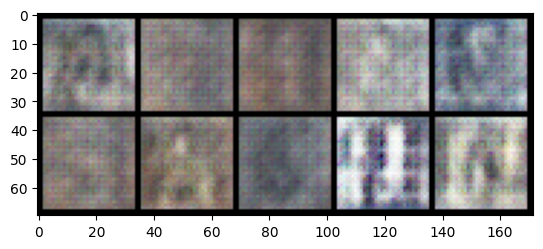

Epoch: 3/100	iter: 0/572	total_iters: 1145	d_loss:0.6101	g_loss:1.584
Epoch: 3/100	iter: 50/572	total_iters: 1195	d_loss:0.4906	g_loss:1.4899
Epoch: 3/100	iter: 100/572	total_iters: 1245	d_loss:0.4704	g_loss:1.1814
Epoch: 3/100	iter: 150/572	total_iters: 1295	d_loss:0.5233	g_loss:1.4817
Epoch: 3/100	iter: 200/572	total_iters: 1345	d_loss:0.5148	g_loss:1.417
Epoch: 3/100	iter: 250/572	total_iters: 1395	d_loss:0.4702	g_loss:1.461
Epoch: 3/100	iter: 300/572	total_iters: 1445	d_loss:0.4513	g_loss:1.3953
Epoch: 3/100	iter: 350/572	total_iters: 1495	d_loss:0.411	g_loss:1.5022
Epoch: 3/100	iter: 400/572	total_iters: 1545	d_loss:0.4204	g_loss:1.6201
Epoch: 3/100	iter: 450/572	total_iters: 1595	d_loss:0.4733	g_loss:1.1311
Epoch: 3/100	iter: 500/572	total_iters: 1645	d_loss:0.4269	g_loss:1.4796
Epoch: 3/100	iter: 550/572	total_iters: 1695	d_loss:0.4939	g_loss:1.4585


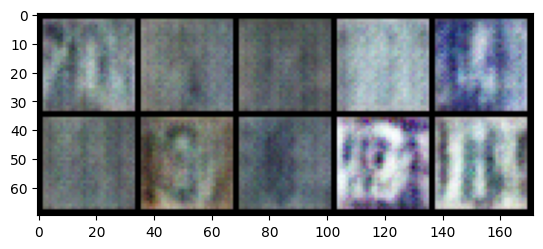

Epoch: 4/100	iter: 0/572	total_iters: 1717	d_loss:0.3818	g_loss:1.7179
Epoch: 4/100	iter: 50/572	total_iters: 1767	d_loss:0.3796	g_loss:1.6125
Epoch: 4/100	iter: 100/572	total_iters: 1817	d_loss:0.3473	g_loss:1.5779
Epoch: 4/100	iter: 150/572	total_iters: 1867	d_loss:0.3395	g_loss:2.1047
Epoch: 4/100	iter: 200/572	total_iters: 1917	d_loss:0.4593	g_loss:2.0439
Epoch: 4/100	iter: 250/572	total_iters: 1967	d_loss:0.3806	g_loss:1.8004
Epoch: 4/100	iter: 300/572	total_iters: 2017	d_loss:0.3853	g_loss:1.807
Epoch: 4/100	iter: 350/572	total_iters: 2067	d_loss:0.4083	g_loss:1.3508
Epoch: 4/100	iter: 400/572	total_iters: 2117	d_loss:0.3961	g_loss:1.3389
Epoch: 4/100	iter: 450/572	total_iters: 2167	d_loss:0.4348	g_loss:1.6464
Epoch: 4/100	iter: 500/572	total_iters: 2217	d_loss:0.4212	g_loss:1.7277
Epoch: 4/100	iter: 550/572	total_iters: 2267	d_loss:0.4186	g_loss:1.3539


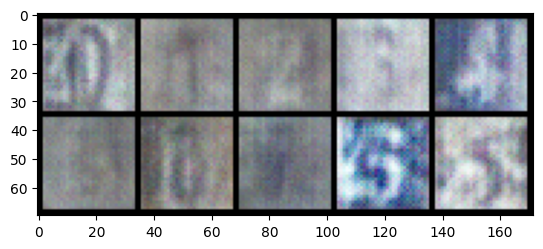

Epoch: 5/100	iter: 0/572	total_iters: 2289	d_loss:0.4951	g_loss:1.8191
Epoch: 5/100	iter: 50/572	total_iters: 2339	d_loss:0.4001	g_loss:1.4382
Epoch: 5/100	iter: 100/572	total_iters: 2389	d_loss:0.451	g_loss:1.8462
Epoch: 5/100	iter: 150/572	total_iters: 2439	d_loss:0.5259	g_loss:0.8903
Epoch: 5/100	iter: 200/572	total_iters: 2489	d_loss:0.4852	g_loss:1.3842
Epoch: 5/100	iter: 250/572	total_iters: 2539	d_loss:0.5033	g_loss:1.6183
Epoch: 5/100	iter: 300/572	total_iters: 2589	d_loss:0.4411	g_loss:1.3813
Epoch: 5/100	iter: 350/572	total_iters: 2639	d_loss:0.4289	g_loss:1.6251
Epoch: 5/100	iter: 400/572	total_iters: 2689	d_loss:0.4848	g_loss:1.5917
Epoch: 5/100	iter: 450/572	total_iters: 2739	d_loss:0.4788	g_loss:2.6012
Epoch: 5/100	iter: 500/572	total_iters: 2789	d_loss:0.5189	g_loss:2.4057
Epoch: 5/100	iter: 550/572	total_iters: 2839	d_loss:0.3779	g_loss:1.3878
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_5.pth


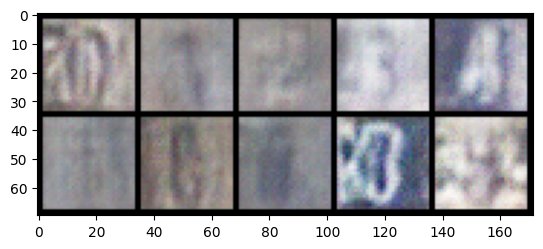

Epoch: 6/100	iter: 0/572	total_iters: 2861	d_loss:0.4704	g_loss:2.2249
Epoch: 6/100	iter: 50/572	total_iters: 2911	d_loss:0.3857	g_loss:2.3265
Epoch: 6/100	iter: 100/572	total_iters: 2961	d_loss:0.3555	g_loss:2.0568
Epoch: 6/100	iter: 150/572	total_iters: 3011	d_loss:0.4747	g_loss:1.2371
Epoch: 6/100	iter: 200/572	total_iters: 3061	d_loss:0.4429	g_loss:1.5429
Epoch: 6/100	iter: 250/572	total_iters: 3111	d_loss:0.5459	g_loss:2.3464
Epoch: 6/100	iter: 300/572	total_iters: 3161	d_loss:0.3982	g_loss:2.1885
Epoch: 6/100	iter: 350/572	total_iters: 3211	d_loss:0.3665	g_loss:2.214
Epoch: 6/100	iter: 400/572	total_iters: 3261	d_loss:0.4787	g_loss:2.2105
Epoch: 6/100	iter: 450/572	total_iters: 3311	d_loss:0.3783	g_loss:1.6979
Epoch: 6/100	iter: 500/572	total_iters: 3361	d_loss:0.358	g_loss:2.5078
Epoch: 6/100	iter: 550/572	total_iters: 3411	d_loss:0.4231	g_loss:1.3511


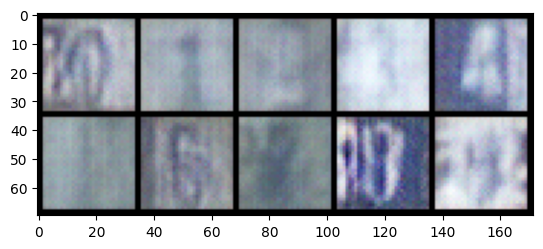

Epoch: 7/100	iter: 0/572	total_iters: 3433	d_loss:0.3624	g_loss:2.1452
Epoch: 7/100	iter: 50/572	total_iters: 3483	d_loss:0.4003	g_loss:2.226
Epoch: 7/100	iter: 100/572	total_iters: 3533	d_loss:0.355	g_loss:2.1283
Epoch: 7/100	iter: 150/572	total_iters: 3583	d_loss:0.5261	g_loss:0.8431
Epoch: 7/100	iter: 200/572	total_iters: 3633	d_loss:0.4552	g_loss:1.7453
Epoch: 7/100	iter: 250/572	total_iters: 3683	d_loss:0.3884	g_loss:2.1391
Epoch: 7/100	iter: 300/572	total_iters: 3733	d_loss:0.325	g_loss:1.9088
Epoch: 7/100	iter: 350/572	total_iters: 3783	d_loss:0.4127	g_loss:2.2729
Epoch: 7/100	iter: 400/572	total_iters: 3833	d_loss:0.548	g_loss:2.3922
Epoch: 7/100	iter: 450/572	total_iters: 3883	d_loss:0.4054	g_loss:1.7527
Epoch: 7/100	iter: 500/572	total_iters: 3933	d_loss:0.2984	g_loss:1.8726
Epoch: 7/100	iter: 550/572	total_iters: 3983	d_loss:0.3082	g_loss:1.9348


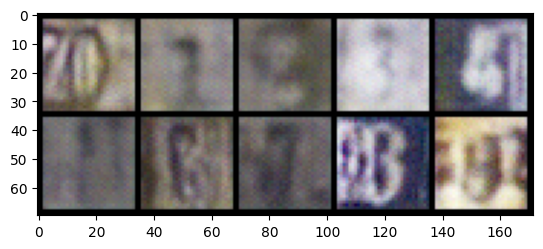

Epoch: 8/100	iter: 0/572	total_iters: 4005	d_loss:0.4367	g_loss:2.1192
Epoch: 8/100	iter: 50/572	total_iters: 4055	d_loss:0.4693	g_loss:2.1822
Epoch: 8/100	iter: 100/572	total_iters: 4105	d_loss:0.2437	g_loss:2.6436
Epoch: 8/100	iter: 150/572	total_iters: 4155	d_loss:0.3967	g_loss:1.4248
Epoch: 8/100	iter: 200/572	total_iters: 4205	d_loss:0.3761	g_loss:1.7897
Epoch: 8/100	iter: 250/572	total_iters: 4255	d_loss:0.4048	g_loss:2.0792
Epoch: 8/100	iter: 300/572	total_iters: 4305	d_loss:0.437	g_loss:1.0337
Epoch: 8/100	iter: 350/572	total_iters: 4355	d_loss:0.5375	g_loss:2.2894
Epoch: 8/100	iter: 400/572	total_iters: 4405	d_loss:0.4185	g_loss:1.4852
Epoch: 8/100	iter: 450/572	total_iters: 4455	d_loss:0.5155	g_loss:2.778
Epoch: 8/100	iter: 500/572	total_iters: 4505	d_loss:0.4286	g_loss:1.2107
Epoch: 8/100	iter: 550/572	total_iters: 4555	d_loss:0.4088	g_loss:2.0495


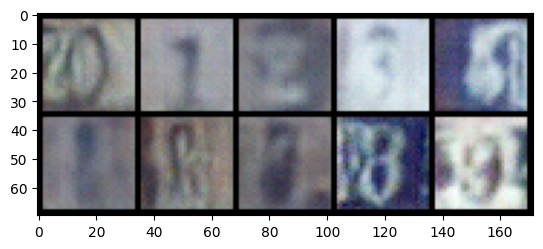

Epoch: 9/100	iter: 0/572	total_iters: 4577	d_loss:0.3066	g_loss:2.3558
Epoch: 9/100	iter: 50/572	total_iters: 4627	d_loss:0.4286	g_loss:1.3251
Epoch: 9/100	iter: 100/572	total_iters: 4677	d_loss:0.414	g_loss:1.8088
Epoch: 9/100	iter: 150/572	total_iters: 4727	d_loss:0.4374	g_loss:1.4994
Epoch: 9/100	iter: 200/572	total_iters: 4777	d_loss:0.3414	g_loss:2.0632
Epoch: 9/100	iter: 250/572	total_iters: 4827	d_loss:0.3958	g_loss:1.3559
Epoch: 9/100	iter: 300/572	total_iters: 4877	d_loss:0.3944	g_loss:1.6867
Epoch: 9/100	iter: 350/572	total_iters: 4927	d_loss:0.3995	g_loss:1.7483
Epoch: 9/100	iter: 400/572	total_iters: 4977	d_loss:0.3618	g_loss:2.5529
Epoch: 9/100	iter: 450/572	total_iters: 5027	d_loss:0.3372	g_loss:2.2591
Epoch: 9/100	iter: 500/572	total_iters: 5077	d_loss:0.3163	g_loss:1.8713
Epoch: 9/100	iter: 550/572	total_iters: 5127	d_loss:0.3692	g_loss:1.7148


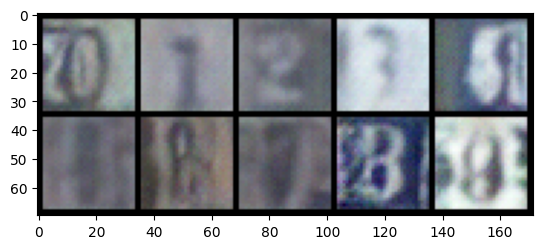

Epoch: 10/100	iter: 0/572	total_iters: 5149	d_loss:0.2979	g_loss:2.1392
Epoch: 10/100	iter: 50/572	total_iters: 5199	d_loss:0.3304	g_loss:2.0224
Epoch: 10/100	iter: 100/572	total_iters: 5249	d_loss:0.4639	g_loss:2.2105
Epoch: 10/100	iter: 150/572	total_iters: 5299	d_loss:0.4463	g_loss:2.6304
Epoch: 10/100	iter: 200/572	total_iters: 5349	d_loss:0.4558	g_loss:1.1179
Epoch: 10/100	iter: 250/572	total_iters: 5399	d_loss:0.4024	g_loss:2.0067
Epoch: 10/100	iter: 300/572	total_iters: 5449	d_loss:0.4344	g_loss:1.5918
Epoch: 10/100	iter: 350/572	total_iters: 5499	d_loss:0.5569	g_loss:0.7941
Epoch: 10/100	iter: 400/572	total_iters: 5549	d_loss:0.4705	g_loss:2.8646
Epoch: 10/100	iter: 450/572	total_iters: 5599	d_loss:0.4417	g_loss:1.0913
Epoch: 10/100	iter: 500/572	total_iters: 5649	d_loss:0.3594	g_loss:1.5755
Epoch: 10/100	iter: 550/572	total_iters: 5699	d_loss:0.4032	g_loss:2.3837
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_10.pth


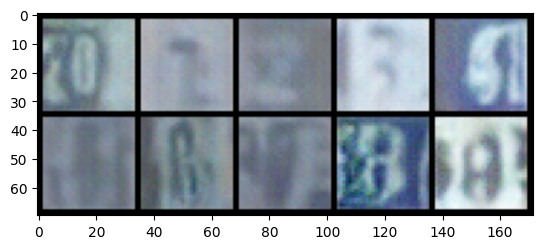

Epoch: 11/100	iter: 0/572	total_iters: 5721	d_loss:0.4396	g_loss:2.7003
Epoch: 11/100	iter: 50/572	total_iters: 5771	d_loss:0.3374	g_loss:1.5947
Epoch: 11/100	iter: 100/572	total_iters: 5821	d_loss:0.3543	g_loss:2.1618
Epoch: 11/100	iter: 150/572	total_iters: 5871	d_loss:0.5173	g_loss:0.6898
Epoch: 11/100	iter: 200/572	total_iters: 5921	d_loss:0.3812	g_loss:1.1354
Epoch: 11/100	iter: 250/572	total_iters: 5971	d_loss:0.3209	g_loss:2.3301
Epoch: 11/100	iter: 300/572	total_iters: 6021	d_loss:0.3829	g_loss:1.8316
Epoch: 11/100	iter: 350/572	total_iters: 6071	d_loss:0.3824	g_loss:1.644
Epoch: 11/100	iter: 400/572	total_iters: 6121	d_loss:0.3773	g_loss:1.5501
Epoch: 11/100	iter: 450/572	total_iters: 6171	d_loss:0.4088	g_loss:1.3504
Epoch: 11/100	iter: 500/572	total_iters: 6221	d_loss:0.3435	g_loss:1.4408
Epoch: 11/100	iter: 550/572	total_iters: 6271	d_loss:0.4005	g_loss:1.1648


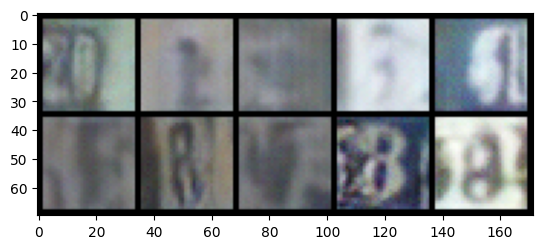

Epoch: 12/100	iter: 0/572	total_iters: 6293	d_loss:0.3335	g_loss:1.5501
Epoch: 12/100	iter: 50/572	total_iters: 6343	d_loss:0.3802	g_loss:2.3444
Epoch: 12/100	iter: 100/572	total_iters: 6393	d_loss:0.3561	g_loss:1.5758
Epoch: 12/100	iter: 150/572	total_iters: 6443	d_loss:0.4403	g_loss:0.9805
Epoch: 12/100	iter: 200/572	total_iters: 6493	d_loss:0.3973	g_loss:1.9467
Epoch: 12/100	iter: 250/572	total_iters: 6543	d_loss:0.327	g_loss:1.9819
Epoch: 12/100	iter: 300/572	total_iters: 6593	d_loss:0.4465	g_loss:1.5388
Epoch: 12/100	iter: 350/572	total_iters: 6643	d_loss:0.491	g_loss:1.2479
Epoch: 12/100	iter: 400/572	total_iters: 6693	d_loss:0.4063	g_loss:1.37
Epoch: 12/100	iter: 450/572	total_iters: 6743	d_loss:0.4062	g_loss:2.0362
Epoch: 12/100	iter: 500/572	total_iters: 6793	d_loss:0.3666	g_loss:2.3417
Epoch: 12/100	iter: 550/572	total_iters: 6843	d_loss:0.4165	g_loss:1.9898


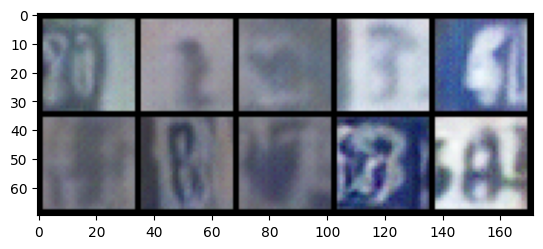

Epoch: 13/100	iter: 0/572	total_iters: 6865	d_loss:0.2799	g_loss:1.9394
Epoch: 13/100	iter: 50/572	total_iters: 6915	d_loss:0.3962	g_loss:2.0904
Epoch: 13/100	iter: 100/572	total_iters: 6965	d_loss:0.272	g_loss:2.7893
Epoch: 13/100	iter: 150/572	total_iters: 7015	d_loss:0.3257	g_loss:1.5976
Epoch: 13/100	iter: 200/572	total_iters: 7065	d_loss:0.3727	g_loss:1.461
Epoch: 13/100	iter: 250/572	total_iters: 7115	d_loss:0.32	g_loss:2.3755
Epoch: 13/100	iter: 300/572	total_iters: 7165	d_loss:0.3402	g_loss:1.9224
Epoch: 13/100	iter: 350/572	total_iters: 7215	d_loss:0.3464	g_loss:1.7962
Epoch: 13/100	iter: 400/572	total_iters: 7265	d_loss:0.3781	g_loss:1.4107
Epoch: 13/100	iter: 450/572	total_iters: 7315	d_loss:0.3229	g_loss:1.9807
Epoch: 13/100	iter: 500/572	total_iters: 7365	d_loss:0.2661	g_loss:2.2833
Epoch: 13/100	iter: 550/572	total_iters: 7415	d_loss:0.4028	g_loss:2.2736


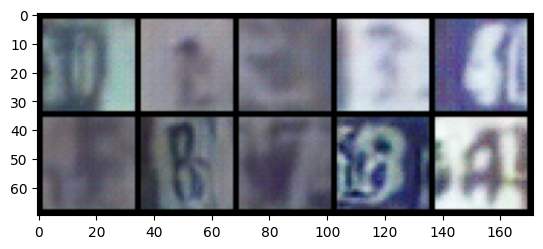

Epoch: 14/100	iter: 0/572	total_iters: 7437	d_loss:0.304	g_loss:1.9845
Epoch: 14/100	iter: 50/572	total_iters: 7487	d_loss:0.2306	g_loss:2.7157
Epoch: 14/100	iter: 100/572	total_iters: 7537	d_loss:0.4991	g_loss:0.7176
Epoch: 14/100	iter: 150/572	total_iters: 7587	d_loss:0.4661	g_loss:1.2682
Epoch: 14/100	iter: 200/572	total_iters: 7637	d_loss:0.3325	g_loss:1.6809
Epoch: 14/100	iter: 250/572	total_iters: 7687	d_loss:0.4305	g_loss:1.5672
Epoch: 14/100	iter: 300/572	total_iters: 7737	d_loss:0.479	g_loss:1.0384
Epoch: 14/100	iter: 350/572	total_iters: 7787	d_loss:0.3168	g_loss:2.6262
Epoch: 14/100	iter: 400/572	total_iters: 7837	d_loss:0.3766	g_loss:2.2952
Epoch: 14/100	iter: 450/572	total_iters: 7887	d_loss:0.2873	g_loss:2.1293
Epoch: 14/100	iter: 500/572	total_iters: 7937	d_loss:0.3185	g_loss:1.977
Epoch: 14/100	iter: 550/572	total_iters: 7987	d_loss:0.6225	g_loss:3.1825


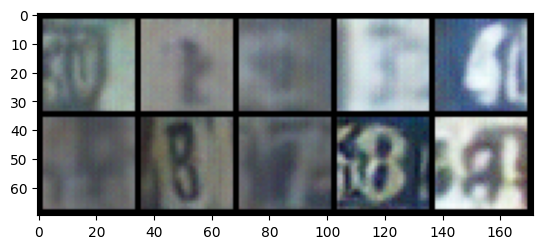

Epoch: 15/100	iter: 0/572	total_iters: 8009	d_loss:0.4062	g_loss:1.3307
Epoch: 15/100	iter: 50/572	total_iters: 8059	d_loss:0.629	g_loss:1.0557
Epoch: 15/100	iter: 100/572	total_iters: 8109	d_loss:0.3928	g_loss:1.7259
Epoch: 15/100	iter: 150/572	total_iters: 8159	d_loss:0.4606	g_loss:1.7472
Epoch: 15/100	iter: 200/572	total_iters: 8209	d_loss:0.5299	g_loss:3.6478
Epoch: 15/100	iter: 250/572	total_iters: 8259	d_loss:0.3813	g_loss:1.1167
Epoch: 15/100	iter: 300/572	total_iters: 8309	d_loss:0.4042	g_loss:1.8343
Epoch: 15/100	iter: 350/572	total_iters: 8359	d_loss:0.288	g_loss:2.5559
Epoch: 15/100	iter: 400/572	total_iters: 8409	d_loss:0.3476	g_loss:1.3474
Epoch: 15/100	iter: 450/572	total_iters: 8459	d_loss:0.2781	g_loss:2.6441
Epoch: 15/100	iter: 500/572	total_iters: 8509	d_loss:0.3426	g_loss:2.7927
Epoch: 15/100	iter: 550/572	total_iters: 8559	d_loss:0.2665	g_loss:2.2549
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_15.pth


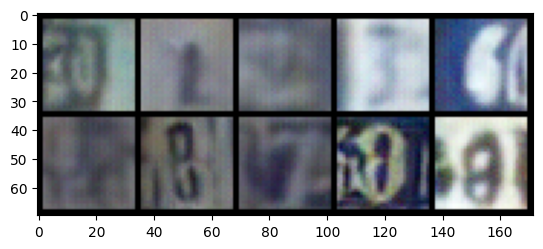

Epoch: 16/100	iter: 0/572	total_iters: 8581	d_loss:0.3464	g_loss:2.9357
Epoch: 16/100	iter: 50/572	total_iters: 8631	d_loss:0.3115	g_loss:3.1066
Epoch: 16/100	iter: 100/572	total_iters: 8681	d_loss:0.3187	g_loss:1.9329
Epoch: 16/100	iter: 150/572	total_iters: 8731	d_loss:0.2805	g_loss:2.1787
Epoch: 16/100	iter: 200/572	total_iters: 8781	d_loss:0.6229	g_loss:1.1279
Epoch: 16/100	iter: 250/572	total_iters: 8831	d_loss:0.3031	g_loss:2.0551
Epoch: 16/100	iter: 300/572	total_iters: 8881	d_loss:0.3428	g_loss:1.7217
Epoch: 16/100	iter: 350/572	total_iters: 8931	d_loss:0.3469	g_loss:1.895
Epoch: 16/100	iter: 400/572	total_iters: 8981	d_loss:0.2623	g_loss:2.1428
Epoch: 16/100	iter: 450/572	total_iters: 9031	d_loss:0.3627	g_loss:2.7368
Epoch: 16/100	iter: 500/572	total_iters: 9081	d_loss:0.4036	g_loss:1.5172
Epoch: 16/100	iter: 550/572	total_iters: 9131	d_loss:0.2561	g_loss:2.4799


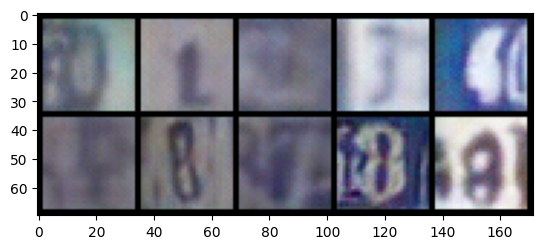

Epoch: 17/100	iter: 0/572	total_iters: 9153	d_loss:0.2582	g_loss:2.2569
Epoch: 17/100	iter: 50/572	total_iters: 9203	d_loss:0.4534	g_loss:2.1448
Epoch: 17/100	iter: 100/572	total_iters: 9253	d_loss:0.2918	g_loss:2.0623
Epoch: 17/100	iter: 150/572	total_iters: 9303	d_loss:0.2523	g_loss:2.8985
Epoch: 17/100	iter: 200/572	total_iters: 9353	d_loss:0.2982	g_loss:2.4989
Epoch: 17/100	iter: 250/572	total_iters: 9403	d_loss:0.2971	g_loss:1.9932
Epoch: 17/100	iter: 300/572	total_iters: 9453	d_loss:0.284	g_loss:2.8526
Epoch: 17/100	iter: 350/572	total_iters: 9503	d_loss:0.2586	g_loss:2.1121
Epoch: 17/100	iter: 400/572	total_iters: 9553	d_loss:0.3709	g_loss:3.0924
Epoch: 17/100	iter: 450/572	total_iters: 9603	d_loss:0.3492	g_loss:2.1182
Epoch: 17/100	iter: 500/572	total_iters: 9653	d_loss:0.326	g_loss:2.6826
Epoch: 17/100	iter: 550/572	total_iters: 9703	d_loss:0.3323	g_loss:3.733


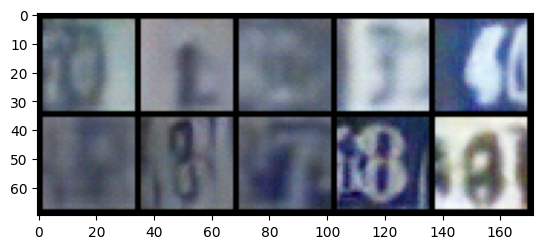

Epoch: 18/100	iter: 0/572	total_iters: 9725	d_loss:0.3581	g_loss:2.6602
Epoch: 18/100	iter: 50/572	total_iters: 9775	d_loss:0.354	g_loss:1.8015
Epoch: 18/100	iter: 100/572	total_iters: 9825	d_loss:0.3508	g_loss:3.6634
Epoch: 18/100	iter: 150/572	total_iters: 9875	d_loss:0.2201	g_loss:2.5682
Epoch: 18/100	iter: 200/572	total_iters: 9925	d_loss:0.3147	g_loss:2.7744
Epoch: 18/100	iter: 250/572	total_iters: 9975	d_loss:0.2657	g_loss:2.2417
Epoch: 18/100	iter: 300/572	total_iters: 10025	d_loss:0.2438	g_loss:3.1916
Epoch: 18/100	iter: 350/572	total_iters: 10075	d_loss:0.3024	g_loss:1.7459
Epoch: 18/100	iter: 400/572	total_iters: 10125	d_loss:0.1984	g_loss:3.3202
Epoch: 18/100	iter: 450/572	total_iters: 10175	d_loss:0.3296	g_loss:2.4904
Epoch: 18/100	iter: 500/572	total_iters: 10225	d_loss:0.434	g_loss:1.2216
Epoch: 18/100	iter: 550/572	total_iters: 10275	d_loss:0.3145	g_loss:1.8595


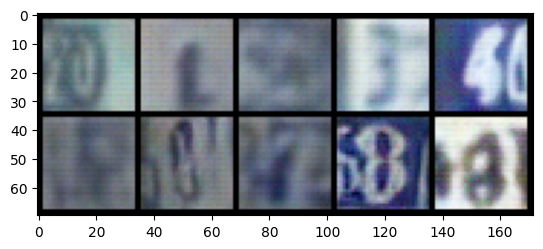

Epoch: 19/100	iter: 0/572	total_iters: 10297	d_loss:0.472	g_loss:2.6887
Epoch: 19/100	iter: 50/572	total_iters: 10347	d_loss:0.2389	g_loss:1.9005
Epoch: 19/100	iter: 100/572	total_iters: 10397	d_loss:0.2001	g_loss:2.3908
Epoch: 19/100	iter: 150/572	total_iters: 10447	d_loss:0.3537	g_loss:1.8412
Epoch: 19/100	iter: 200/572	total_iters: 10497	d_loss:0.213	g_loss:2.7615
Epoch: 19/100	iter: 250/572	total_iters: 10547	d_loss:0.2716	g_loss:2.1826
Epoch: 19/100	iter: 300/572	total_iters: 10597	d_loss:0.2133	g_loss:2.5012
Epoch: 19/100	iter: 350/572	total_iters: 10647	d_loss:0.353	g_loss:1.5888
Epoch: 19/100	iter: 400/572	total_iters: 10697	d_loss:0.3767	g_loss:2.3409
Epoch: 19/100	iter: 450/572	total_iters: 10747	d_loss:0.5584	g_loss:1.5504
Epoch: 19/100	iter: 500/572	total_iters: 10797	d_loss:0.3657	g_loss:2.6132
Epoch: 19/100	iter: 550/572	total_iters: 10847	d_loss:0.248	g_loss:3.054


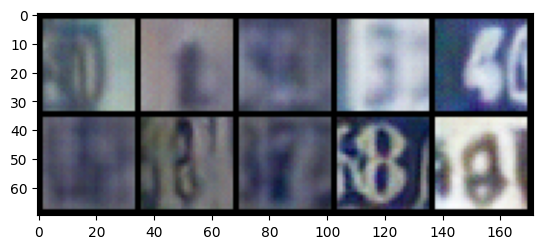

Epoch: 20/100	iter: 0/572	total_iters: 10869	d_loss:0.2723	g_loss:2.0762
Epoch: 20/100	iter: 50/572	total_iters: 10919	d_loss:0.2563	g_loss:2.179
Epoch: 20/100	iter: 100/572	total_iters: 10969	d_loss:0.2946	g_loss:2.4549
Epoch: 20/100	iter: 150/572	total_iters: 11019	d_loss:0.2907	g_loss:2.188
Epoch: 20/100	iter: 200/572	total_iters: 11069	d_loss:0.2058	g_loss:2.992
Epoch: 20/100	iter: 250/572	total_iters: 11119	d_loss:0.354	g_loss:1.8118
Epoch: 20/100	iter: 300/572	total_iters: 11169	d_loss:0.4635	g_loss:3.6854
Epoch: 20/100	iter: 350/572	total_iters: 11219	d_loss:0.3045	g_loss:3.3996
Epoch: 20/100	iter: 400/572	total_iters: 11269	d_loss:0.2211	g_loss:3.4527
Epoch: 20/100	iter: 450/572	total_iters: 11319	d_loss:0.2766	g_loss:2.3912
Epoch: 20/100	iter: 500/572	total_iters: 11369	d_loss:0.2446	g_loss:2.2425
Epoch: 20/100	iter: 550/572	total_iters: 11419	d_loss:0.2695	g_loss:3.2811
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_20.pth


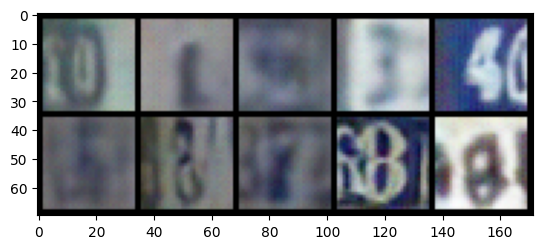

Epoch: 21/100	iter: 0/572	total_iters: 11441	d_loss:0.2591	g_loss:2.2461
Epoch: 21/100	iter: 50/572	total_iters: 11491	d_loss:0.2113	g_loss:2.4422
Epoch: 21/100	iter: 100/572	total_iters: 11541	d_loss:0.3548	g_loss:1.8148
Epoch: 21/100	iter: 150/572	total_iters: 11591	d_loss:0.2362	g_loss:2.8842
Epoch: 21/100	iter: 200/572	total_iters: 11641	d_loss:0.4609	g_loss:3.3243
Epoch: 21/100	iter: 250/572	total_iters: 11691	d_loss:0.3027	g_loss:2.5504
Epoch: 21/100	iter: 300/572	total_iters: 11741	d_loss:0.2448	g_loss:2.1717
Epoch: 21/100	iter: 350/572	total_iters: 11791	d_loss:0.3578	g_loss:1.2507
Epoch: 21/100	iter: 400/572	total_iters: 11841	d_loss:0.2713	g_loss:2.8616
Epoch: 21/100	iter: 450/572	total_iters: 11891	d_loss:0.2733	g_loss:2.2408
Epoch: 21/100	iter: 500/572	total_iters: 11941	d_loss:0.2192	g_loss:2.7597
Epoch: 21/100	iter: 550/572	total_iters: 11991	d_loss:0.2986	g_loss:2.6841


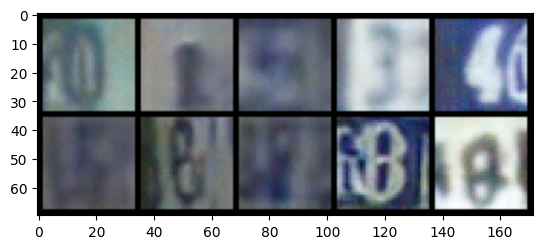

Epoch: 22/100	iter: 0/572	total_iters: 12013	d_loss:0.7999	g_loss:2.8375
Epoch: 22/100	iter: 50/572	total_iters: 12063	d_loss:0.3359	g_loss:1.7219
Epoch: 22/100	iter: 100/572	total_iters: 12113	d_loss:0.2787	g_loss:2.8506
Epoch: 22/100	iter: 150/572	total_iters: 12163	d_loss:0.4767	g_loss:1.0971
Epoch: 22/100	iter: 200/572	total_iters: 12213	d_loss:0.3168	g_loss:2.9137
Epoch: 22/100	iter: 250/572	total_iters: 12263	d_loss:0.2235	g_loss:2.086
Epoch: 22/100	iter: 300/572	total_iters: 12313	d_loss:0.289	g_loss:2.3226
Epoch: 22/100	iter: 350/572	total_iters: 12363	d_loss:0.2243	g_loss:2.7257
Epoch: 22/100	iter: 400/572	total_iters: 12413	d_loss:0.2309	g_loss:2.9376
Epoch: 22/100	iter: 450/572	total_iters: 12463	d_loss:0.2298	g_loss:2.8071
Epoch: 22/100	iter: 500/572	total_iters: 12513	d_loss:0.2893	g_loss:1.9564
Epoch: 22/100	iter: 550/572	total_iters: 12563	d_loss:0.2436	g_loss:2.665


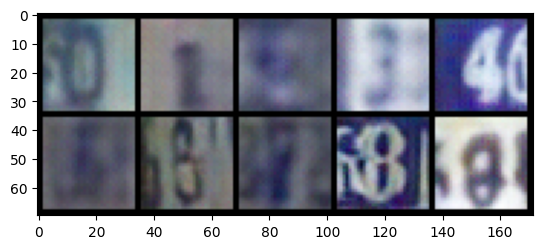

Epoch: 23/100	iter: 0/572	total_iters: 12585	d_loss:0.2537	g_loss:3.2878
Epoch: 23/100	iter: 50/572	total_iters: 12635	d_loss:0.2252	g_loss:2.4072
Epoch: 23/100	iter: 100/572	total_iters: 12685	d_loss:0.3021	g_loss:2.3016
Epoch: 23/100	iter: 150/572	total_iters: 12735	d_loss:0.1941	g_loss:3.3021
Epoch: 23/100	iter: 200/572	total_iters: 12785	d_loss:0.4252	g_loss:3.7714
Epoch: 23/100	iter: 250/572	total_iters: 12835	d_loss:0.3361	g_loss:1.6372
Epoch: 23/100	iter: 300/572	total_iters: 12885	d_loss:0.2287	g_loss:2.619
Epoch: 23/100	iter: 350/572	total_iters: 12935	d_loss:0.4028	g_loss:2.8276
Epoch: 23/100	iter: 400/572	total_iters: 12985	d_loss:0.224	g_loss:2.3797
Epoch: 23/100	iter: 450/572	total_iters: 13035	d_loss:0.2828	g_loss:2.1934
Epoch: 23/100	iter: 500/572	total_iters: 13085	d_loss:0.2549	g_loss:2.5767
Epoch: 23/100	iter: 550/572	total_iters: 13135	d_loss:0.3883	g_loss:1.4822


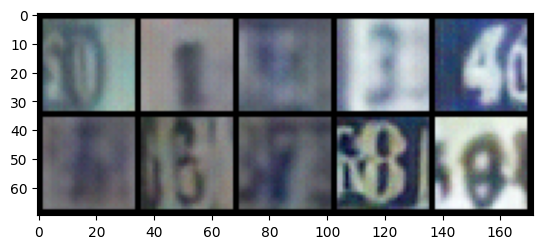

Epoch: 24/100	iter: 0/572	total_iters: 13157	d_loss:0.224	g_loss:2.3039
Epoch: 24/100	iter: 50/572	total_iters: 13207	d_loss:0.2329	g_loss:3.0429
Epoch: 24/100	iter: 100/572	total_iters: 13257	d_loss:0.2471	g_loss:2.6796
Epoch: 24/100	iter: 150/572	total_iters: 13307	d_loss:0.2238	g_loss:2.4931
Epoch: 24/100	iter: 200/572	total_iters: 13357	d_loss:0.4035	g_loss:1.2931
Epoch: 24/100	iter: 250/572	total_iters: 13407	d_loss:0.309	g_loss:2.8841
Epoch: 24/100	iter: 300/572	total_iters: 13457	d_loss:0.233	g_loss:2.2587
Epoch: 24/100	iter: 350/572	total_iters: 13507	d_loss:0.3843	g_loss:1.1221
Epoch: 24/100	iter: 400/572	total_iters: 13557	d_loss:0.2177	g_loss:2.8731
Epoch: 24/100	iter: 450/572	total_iters: 13607	d_loss:0.8539	g_loss:0.5777
Epoch: 24/100	iter: 500/572	total_iters: 13657	d_loss:0.2222	g_loss:2.4385
Epoch: 24/100	iter: 550/572	total_iters: 13707	d_loss:0.2604	g_loss:2.276


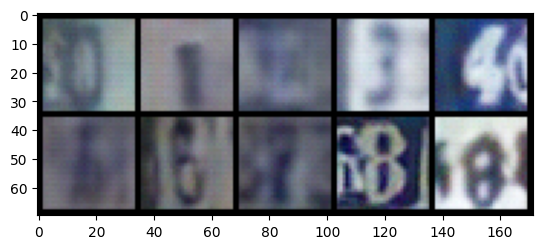

Epoch: 25/100	iter: 0/572	total_iters: 13729	d_loss:0.1784	g_loss:2.5585
Epoch: 25/100	iter: 50/572	total_iters: 13779	d_loss:0.1875	g_loss:2.7985
Epoch: 25/100	iter: 100/572	total_iters: 13829	d_loss:0.2216	g_loss:2.0868
Epoch: 25/100	iter: 150/572	total_iters: 13879	d_loss:0.1664	g_loss:2.8235
Epoch: 25/100	iter: 200/572	total_iters: 13929	d_loss:0.4893	g_loss:1.4453
Epoch: 25/100	iter: 250/572	total_iters: 13979	d_loss:0.2018	g_loss:3.1142
Epoch: 25/100	iter: 300/572	total_iters: 14029	d_loss:0.1774	g_loss:3.0457
Epoch: 25/100	iter: 350/572	total_iters: 14079	d_loss:0.2194	g_loss:2.312
Epoch: 25/100	iter: 400/572	total_iters: 14129	d_loss:0.3636	g_loss:2.2881
Epoch: 25/100	iter: 450/572	total_iters: 14179	d_loss:0.3577	g_loss:1.6503
Epoch: 25/100	iter: 500/572	total_iters: 14229	d_loss:0.2556	g_loss:2.3854
Epoch: 25/100	iter: 550/572	total_iters: 14279	d_loss:0.2358	g_loss:1.9246
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_25.pth


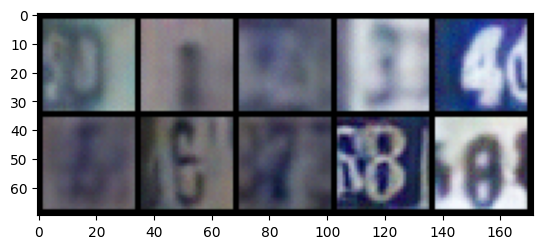

Epoch: 26/100	iter: 0/572	total_iters: 14301	d_loss:0.2496	g_loss:1.9367
Epoch: 26/100	iter: 50/572	total_iters: 14351	d_loss:0.2224	g_loss:3.3474
Epoch: 26/100	iter: 100/572	total_iters: 14401	d_loss:0.2451	g_loss:3.0994
Epoch: 26/100	iter: 150/572	total_iters: 14451	d_loss:0.3797	g_loss:4.1693
Epoch: 26/100	iter: 200/572	total_iters: 14501	d_loss:1.1363	g_loss:0.6411
Epoch: 26/100	iter: 250/572	total_iters: 14551	d_loss:0.1755	g_loss:3.2587
Epoch: 26/100	iter: 300/572	total_iters: 14601	d_loss:0.3044	g_loss:2.6726
Epoch: 26/100	iter: 350/572	total_iters: 14651	d_loss:0.1925	g_loss:2.7353
Epoch: 26/100	iter: 400/572	total_iters: 14701	d_loss:0.2535	g_loss:2.7527
Epoch: 26/100	iter: 450/572	total_iters: 14751	d_loss:0.3006	g_loss:1.9472
Epoch: 26/100	iter: 500/572	total_iters: 14801	d_loss:0.1665	g_loss:2.8259
Epoch: 26/100	iter: 550/572	total_iters: 14851	d_loss:0.3301	g_loss:1.6862


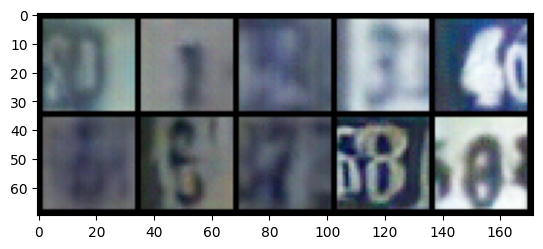

Epoch: 27/100	iter: 0/572	total_iters: 14873	d_loss:0.2814	g_loss:2.663
Epoch: 27/100	iter: 50/572	total_iters: 14923	d_loss:0.2627	g_loss:2.12
Epoch: 27/100	iter: 100/572	total_iters: 14973	d_loss:0.2292	g_loss:2.5364
Epoch: 27/100	iter: 150/572	total_iters: 15023	d_loss:0.1571	g_loss:3.1186
Epoch: 27/100	iter: 200/572	total_iters: 15073	d_loss:0.2139	g_loss:2.7116
Epoch: 27/100	iter: 250/572	total_iters: 15123	d_loss:0.2806	g_loss:2.9432
Epoch: 27/100	iter: 300/572	total_iters: 15173	d_loss:0.4023	g_loss:3.4726
Epoch: 27/100	iter: 350/572	total_iters: 15223	d_loss:0.1748	g_loss:3.4238
Epoch: 27/100	iter: 400/572	total_iters: 15273	d_loss:0.3922	g_loss:3.305
Epoch: 27/100	iter: 450/572	total_iters: 15323	d_loss:0.4358	g_loss:3.4762
Epoch: 27/100	iter: 500/572	total_iters: 15373	d_loss:0.1824	g_loss:1.9177
Epoch: 27/100	iter: 550/572	total_iters: 15423	d_loss:0.2538	g_loss:2.6298


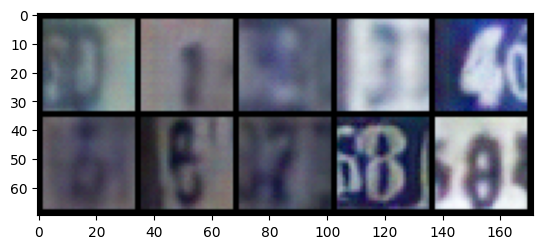

Epoch: 28/100	iter: 0/572	total_iters: 15445	d_loss:0.2264	g_loss:2.5804
Epoch: 28/100	iter: 50/572	total_iters: 15495	d_loss:0.1946	g_loss:3.4973
Epoch: 28/100	iter: 100/572	total_iters: 15545	d_loss:0.2389	g_loss:2.1233
Epoch: 28/100	iter: 150/572	total_iters: 15595	d_loss:0.3629	g_loss:1.6626
Epoch: 28/100	iter: 200/572	total_iters: 15645	d_loss:0.2861	g_loss:2.1136
Epoch: 28/100	iter: 250/572	total_iters: 15695	d_loss:0.3879	g_loss:3.7642
Epoch: 28/100	iter: 300/572	total_iters: 15745	d_loss:0.2203	g_loss:2.6634
Epoch: 28/100	iter: 350/572	total_iters: 15795	d_loss:0.3085	g_loss:3.3776
Epoch: 28/100	iter: 400/572	total_iters: 15845	d_loss:0.2172	g_loss:2.5847
Epoch: 28/100	iter: 450/572	total_iters: 15895	d_loss:0.1714	g_loss:3.3358
Epoch: 28/100	iter: 500/572	total_iters: 15945	d_loss:0.1984	g_loss:2.9009
Epoch: 28/100	iter: 550/572	total_iters: 15995	d_loss:0.3114	g_loss:2.0729


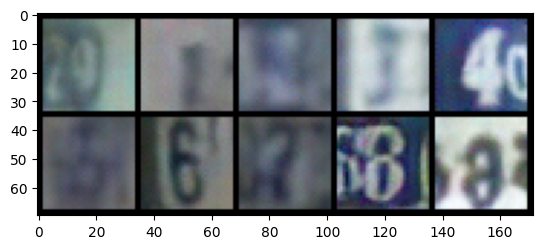

Epoch: 29/100	iter: 0/572	total_iters: 16017	d_loss:0.2753	g_loss:2.5345
Epoch: 29/100	iter: 50/572	total_iters: 16067	d_loss:0.1775	g_loss:2.7742
Epoch: 29/100	iter: 100/572	total_iters: 16117	d_loss:0.171	g_loss:4.1886
Epoch: 29/100	iter: 150/572	total_iters: 16167	d_loss:0.2257	g_loss:2.8895
Epoch: 29/100	iter: 200/572	total_iters: 16217	d_loss:0.2278	g_loss:2.6249
Epoch: 29/100	iter: 250/572	total_iters: 16267	d_loss:0.1557	g_loss:2.526
Epoch: 29/100	iter: 300/572	total_iters: 16317	d_loss:0.3346	g_loss:1.976
Epoch: 29/100	iter: 350/572	total_iters: 16367	d_loss:0.3772	g_loss:3.5785
Epoch: 29/100	iter: 400/572	total_iters: 16417	d_loss:0.2299	g_loss:2.8428
Epoch: 29/100	iter: 450/572	total_iters: 16467	d_loss:0.2085	g_loss:3.1745
Epoch: 29/100	iter: 500/572	total_iters: 16517	d_loss:0.2863	g_loss:2.8146
Epoch: 29/100	iter: 550/572	total_iters: 16567	d_loss:0.2037	g_loss:2.0652


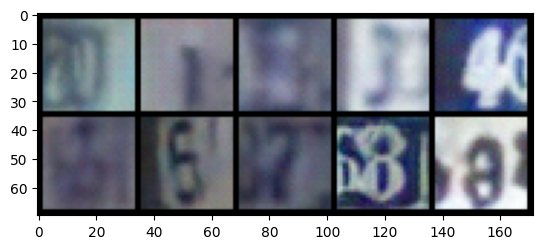

Epoch: 30/100	iter: 0/572	total_iters: 16589	d_loss:0.2235	g_loss:3.9583
Epoch: 30/100	iter: 50/572	total_iters: 16639	d_loss:0.236	g_loss:2.5716
Epoch: 30/100	iter: 100/572	total_iters: 16689	d_loss:0.1814	g_loss:2.7646
Epoch: 30/100	iter: 150/572	total_iters: 16739	d_loss:0.2446	g_loss:2.4068
Epoch: 30/100	iter: 200/572	total_iters: 16789	d_loss:0.2576	g_loss:2.6017
Epoch: 30/100	iter: 250/572	total_iters: 16839	d_loss:0.1943	g_loss:2.6818
Epoch: 30/100	iter: 300/572	total_iters: 16889	d_loss:0.2403	g_loss:3.2629
Epoch: 30/100	iter: 350/572	total_iters: 16939	d_loss:0.2985	g_loss:2.3353
Epoch: 30/100	iter: 400/572	total_iters: 16989	d_loss:0.221	g_loss:2.9275
Epoch: 30/100	iter: 450/572	total_iters: 17039	d_loss:0.2191	g_loss:2.3012
Epoch: 30/100	iter: 500/572	total_iters: 17089	d_loss:0.4152	g_loss:3.2331
Epoch: 30/100	iter: 550/572	total_iters: 17139	d_loss:0.2615	g_loss:1.9386
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_30.pth


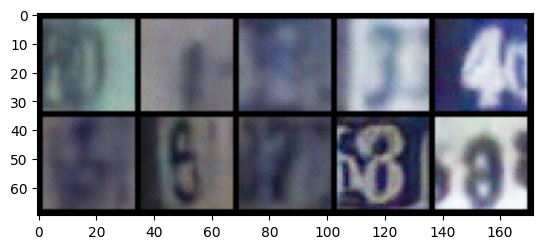

Epoch: 31/100	iter: 0/572	total_iters: 17161	d_loss:0.1776	g_loss:2.4908
Epoch: 31/100	iter: 50/572	total_iters: 17211	d_loss:0.1654	g_loss:2.8613
Epoch: 31/100	iter: 100/572	total_iters: 17261	d_loss:0.254	g_loss:2.5597
Epoch: 31/100	iter: 150/572	total_iters: 17311	d_loss:0.1568	g_loss:3.7264
Epoch: 31/100	iter: 200/572	total_iters: 17361	d_loss:0.3017	g_loss:4.2903
Epoch: 31/100	iter: 250/572	total_iters: 17411	d_loss:0.1851	g_loss:3.3692
Epoch: 31/100	iter: 300/572	total_iters: 17461	d_loss:0.1869	g_loss:3.1091
Epoch: 31/100	iter: 350/572	total_iters: 17511	d_loss:0.2467	g_loss:2.7974
Epoch: 31/100	iter: 400/572	total_iters: 17561	d_loss:0.3807	g_loss:3.7941
Epoch: 31/100	iter: 450/572	total_iters: 17611	d_loss:0.2906	g_loss:3.4654
Epoch: 31/100	iter: 500/572	total_iters: 17661	d_loss:0.3395	g_loss:2.5067
Epoch: 31/100	iter: 550/572	total_iters: 17711	d_loss:0.3917	g_loss:1.7044


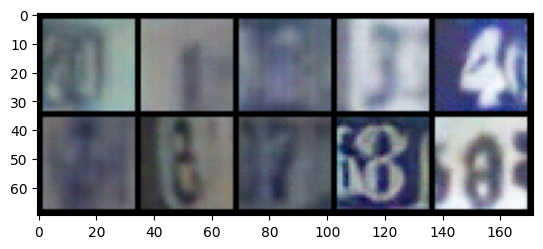

Epoch: 32/100	iter: 0/572	total_iters: 17733	d_loss:0.265	g_loss:2.6607
Epoch: 32/100	iter: 50/572	total_iters: 17783	d_loss:0.2036	g_loss:2.8095
Epoch: 32/100	iter: 100/572	total_iters: 17833	d_loss:0.2362	g_loss:2.3591
Epoch: 32/100	iter: 150/572	total_iters: 17883	d_loss:0.2292	g_loss:2.2406
Epoch: 32/100	iter: 200/572	total_iters: 17933	d_loss:0.2921	g_loss:2.7078
Epoch: 32/100	iter: 250/572	total_iters: 17983	d_loss:0.4066	g_loss:3.5607
Epoch: 32/100	iter: 300/572	total_iters: 18033	d_loss:0.2007	g_loss:2.8258
Epoch: 32/100	iter: 350/572	total_iters: 18083	d_loss:0.3443	g_loss:2.0026
Epoch: 32/100	iter: 400/572	total_iters: 18133	d_loss:0.2245	g_loss:2.3702
Epoch: 32/100	iter: 450/572	total_iters: 18183	d_loss:1.0986	g_loss:0.6965
Epoch: 32/100	iter: 500/572	total_iters: 18233	d_loss:0.2545	g_loss:1.9608
Epoch: 32/100	iter: 550/572	total_iters: 18283	d_loss:0.3826	g_loss:1.6554


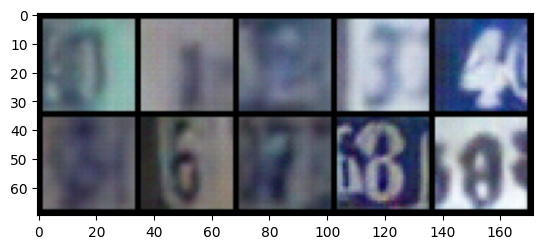

Epoch: 33/100	iter: 0/572	total_iters: 18305	d_loss:0.2009	g_loss:3.6949
Epoch: 33/100	iter: 50/572	total_iters: 18355	d_loss:0.2206	g_loss:2.9074
Epoch: 33/100	iter: 100/572	total_iters: 18405	d_loss:0.2704	g_loss:1.4913
Epoch: 33/100	iter: 150/572	total_iters: 18455	d_loss:0.2311	g_loss:2.3845
Epoch: 33/100	iter: 200/572	total_iters: 18505	d_loss:0.251	g_loss:2.7222
Epoch: 33/100	iter: 250/572	total_iters: 18555	d_loss:0.2895	g_loss:2.3342
Epoch: 33/100	iter: 300/572	total_iters: 18605	d_loss:0.1922	g_loss:2.5365
Epoch: 33/100	iter: 350/572	total_iters: 18655	d_loss:0.4589	g_loss:1.7989
Epoch: 33/100	iter: 400/572	total_iters: 18705	d_loss:0.1529	g_loss:2.9989
Epoch: 33/100	iter: 450/572	total_iters: 18755	d_loss:0.2929	g_loss:1.9538
Epoch: 33/100	iter: 500/572	total_iters: 18805	d_loss:0.3789	g_loss:2.336
Epoch: 33/100	iter: 550/572	total_iters: 18855	d_loss:0.2207	g_loss:2.5547


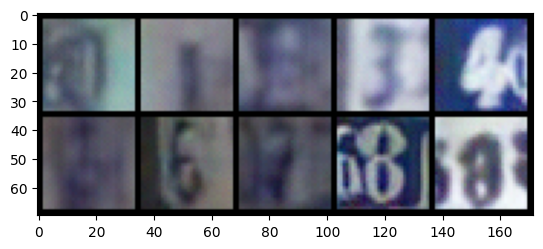

Epoch: 34/100	iter: 0/572	total_iters: 18877	d_loss:0.2284	g_loss:3.4458
Epoch: 34/100	iter: 50/572	total_iters: 18927	d_loss:0.2879	g_loss:3.3684
Epoch: 34/100	iter: 100/572	total_iters: 18977	d_loss:0.3519	g_loss:2.2229
Epoch: 34/100	iter: 150/572	total_iters: 19027	d_loss:0.2411	g_loss:3.1253
Epoch: 34/100	iter: 200/572	total_iters: 19077	d_loss:0.1937	g_loss:2.9317
Epoch: 34/100	iter: 250/572	total_iters: 19127	d_loss:0.4105	g_loss:0.7103
Epoch: 34/100	iter: 300/572	total_iters: 19177	d_loss:0.2055	g_loss:3.2037
Epoch: 34/100	iter: 350/572	total_iters: 19227	d_loss:0.2967	g_loss:2.1251
Epoch: 34/100	iter: 400/572	total_iters: 19277	d_loss:0.1964	g_loss:2.4693
Epoch: 34/100	iter: 450/572	total_iters: 19327	d_loss:0.2396	g_loss:2.8252
Epoch: 34/100	iter: 500/572	total_iters: 19377	d_loss:0.2522	g_loss:2.8077
Epoch: 34/100	iter: 550/572	total_iters: 19427	d_loss:0.2244	g_loss:2.4124


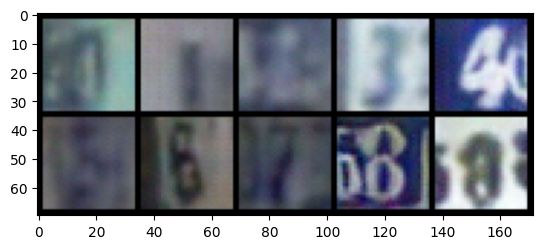

Epoch: 35/100	iter: 0/572	total_iters: 19449	d_loss:0.2303	g_loss:2.5305
Epoch: 35/100	iter: 50/572	total_iters: 19499	d_loss:0.3512	g_loss:3.3701
Epoch: 35/100	iter: 100/572	total_iters: 19549	d_loss:0.154	g_loss:3.0959
Epoch: 35/100	iter: 150/572	total_iters: 19599	d_loss:0.1974	g_loss:2.9509
Epoch: 35/100	iter: 200/572	total_iters: 19649	d_loss:0.2023	g_loss:2.998
Epoch: 35/100	iter: 250/572	total_iters: 19699	d_loss:0.1913	g_loss:2.8744
Epoch: 35/100	iter: 300/572	total_iters: 19749	d_loss:0.3233	g_loss:4.1999
Epoch: 35/100	iter: 350/572	total_iters: 19799	d_loss:0.3247	g_loss:1.3319
Epoch: 35/100	iter: 400/572	total_iters: 19849	d_loss:0.2495	g_loss:1.8601
Epoch: 35/100	iter: 450/572	total_iters: 19899	d_loss:0.4153	g_loss:1.7922
Epoch: 35/100	iter: 500/572	total_iters: 19949	d_loss:0.1893	g_loss:2.8953
Epoch: 35/100	iter: 550/572	total_iters: 19999	d_loss:0.1468	g_loss:2.6497
Checkpoint saved at: /content/gdrive/MyDrive/hodl/checkpoint_epoch_35.pth


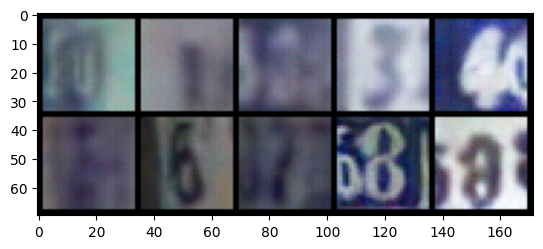

Epoch: 36/100	iter: 0/572	total_iters: 20021	d_loss:0.1892	g_loss:3.2193
Epoch: 36/100	iter: 50/572	total_iters: 20071	d_loss:0.2523	g_loss:2.003
Epoch: 36/100	iter: 100/572	total_iters: 20121	d_loss:0.2736	g_loss:2.1792


KeyboardInterrupt: 

In [102]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)

# Define Optimizers
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

# Loss functions
loss_fn = nn.BCELoss()

# Labels
real_label = torch.ones(BATCH_SIZE)
fake_label = torch.zeros(BATCH_SIZE)

# GPU Compatibility
is_cuda = torch.cuda.is_available()
if is_cuda:
    gen, dis = gen.cuda(), dis.cuda()
    real_label, fake_label = real_label.cuda(), fake_label.cuda()


total_iters = 0
max_iter = len(data_loader)

# seed
torch.manual_seed(0)
np.random.seed(0)

z_val = torch.randn(10, Z_DIM).cuda()
label = torch.tensor([0,1,2,3,4,5,6,7,8,9]).cuda()

# Training
for epoch in range(EPOCHS):

    gen.eval()

    sample_images = gen(z_val, label).cpu()

    # Show images
    grid = make_grid(sample_images, nrow=5, normalize=True).permute(1, 2, 0).numpy()
    plt.imshow(grid)
    plt.show()

    gen.train()
    dis.train()

    for i, data in enumerate(data_loader):

        total_iters += 1

        # Loading data
        x_real, x_label = data
        z_fake = torch.randn(BATCH_SIZE, Z_DIM)

        if is_cuda:
            x_real = x_real.cuda()
            x_label = x_label.cuda()
            z_fake = z_fake.cuda()

        # Generate fake data
        x_fake = gen(z_fake, x_label)

        # Train Discriminator
        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)
        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

    if (epoch + 1) % 5 == 0:
        save_checkpoint(gen, g_opt, epoch + 1, g_loss.item())
        #save_checkpoint(dis, d_opt, epoch + 1, d_loss.item())

In [ ]:
team_members = ["buerki", "urban", "huber"]
assert len(team_members) > 0